# Preprocessing per classificazione multiclasse su `category`



 Valori mancanti prima del trattamento:
selfMade_encoded                         0
log_finalWorth                           0
age                                     65
log_gdp_country                        164
cpi_country                            184
life_expectancy_country                182
gross_tertiary_education_enrollment    182
total_tax_rate_country                 182
population_country                     164
dtype: int64

 Numero di outlier per variabile:
selfMade_encoded_outlier                         0
log_finalWorth_outlier                          81
age_outlier                                     10
log_gdp_country_outlier                         30
cpi_country_outlier                            469
life_expectancy_country_outlier                182
gross_tertiary_education_enrollment_outlier      0
total_tax_rate_country_outlier                   4
population_country_outlier                       0
dtype: int64

 Dataset pronto per la classificazione su 'category

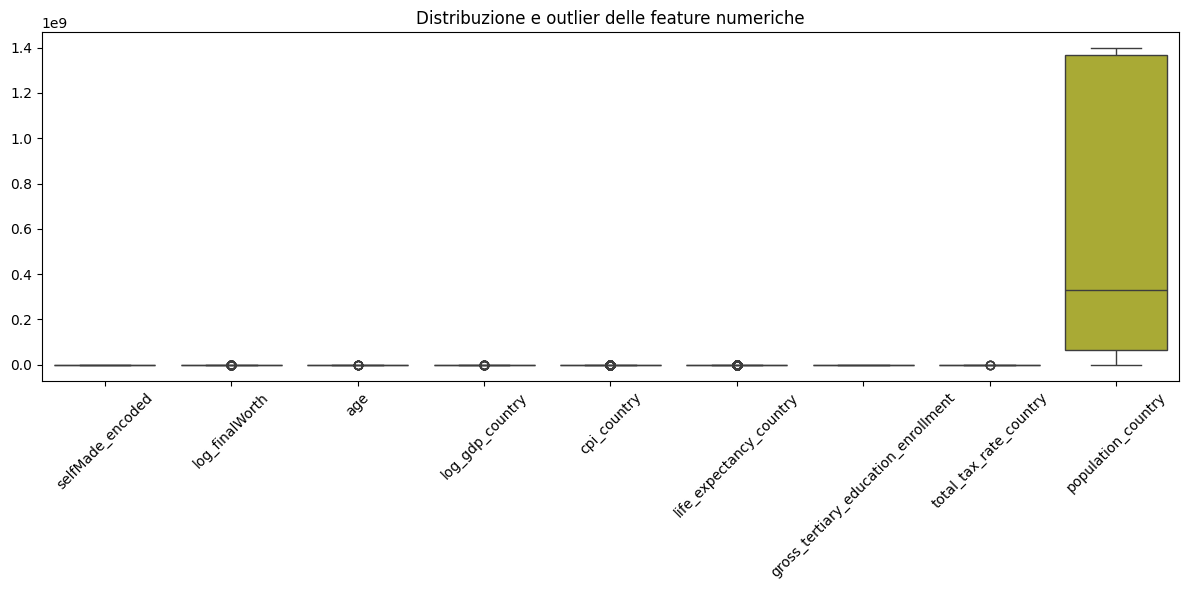

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# === 1. Percorsi e Caricamento ===
INPUT_PATH = "../data/raw/Billionaires Statistics Dataset.csv"
OUTPUT_DIR = "../data/splitted_category"
os.makedirs(OUTPUT_DIR, exist_ok=True)

df = pd.read_csv(INPUT_PATH)
df = df.drop_duplicates()

df['gdp_country'] = df['gdp_country'].astype(str).str.replace("$", "", regex=False)
df['gdp_country'] = df['gdp_country'].str.replace(",", "").str.strip()
df['gdp_country'] = pd.to_numeric(df['gdp_country'], errors='coerce')



# === 2. Trasformazioni logaritmiche ===
df["log_finalWorth"] = np.log1p(df["finalWorth"])
df["log_gdp_country"] = np.log1p(df["gdp_country"])
df["selfMade_encoded"] = df["selfMade"].map({True: 1, False: 0})




# === 3. Selezione colonne utili ===
numerical_cols = ['selfMade_encoded', 'log_finalWorth', 'age', 'log_gdp_country', 'cpi_country',
                  'life_expectancy_country', 'gross_tertiary_education_enrollment',
                  'total_tax_rate_country', 'population_country']

categorical_cols = ['country', 'source', 'gender', 'status']

# === 4. Gestione NaN ===
print("\n Valori mancanti prima del trattamento:")
print(df[numerical_cols].isnull().sum())

for col in numerical_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)


# === 5. Identificazione outlier (IQR) ===
outlier_mask = pd.DataFrame(index=df.index)
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_mask[col + '_outlier'] = ~df[col].between(lower, upper)

print("\n Numero di outlier per variabile:")
print(outlier_mask.sum())


# === 6. Encoding categoriche ===
categorical_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

# === 7. Target ===
# Mappatura delle categorie in macro-classi

category_map = {
    'Automotive': 'Industry',
    'Construction & Engineering': 'Industry',
    'Manufacturing': 'Industry',
    'Metals & Mining': 'Industry',
    'Logistics': 'Industry',
    'Finance & Investments': 'Finance & Real Estate',
    'Real Estate': 'Finance & Real Estate',
    'Food & Beverage': 'Consumer & Leisure',
    'Gambling & Casinos': 'Consumer & Leisure',
    'Fashion & Retail': 'Media & Culture',
    'Media & Entertainment': 'Media & Culture',
    'Service': 'Media & Culture',
    'Sports': 'Media & Culture',
    'Healthcare': 'Health & Tech',
    'Telecom': 'Health & Tech',
    'Technology': 'Health & Tech',
    'Energy': 'Energy',
    'Diversified': 'Diversified'
}

df["new_category"] = df["category"].map(category_map)

target = 'new_category'
y = df[target]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

joblib.dump(le, "../models/label_encoder_category.joblib")

df = df.drop(columns=["category", "new_category"])






# === 8. Costruzione dataset finale ===
X = pd.concat([df[numerical_cols], categorical_encoded], axis=1)

# === 9. Rimozione record con target mancante ===
mask = y.notna()
X = X[mask]
y_encoded = y_encoded[mask]

# === 10. Split train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# === 11. Salvataggio ===
X_train.to_csv(os.path.join(OUTPUT_DIR, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(OUTPUT_DIR, "X_test.csv"), index=False)
pd.Series(y_train, name="category_encoded").to_csv(os.path.join(OUTPUT_DIR, "y_train.csv"), index=False)
pd.Series(y_test, name="category_encoded").to_csv(os.path.join(OUTPUT_DIR, "y_test.csv"), index=False)

print("\n Dataset pronto per la classificazione su 'category'. Salvato in '../data/splitted_category/'")


# === 13. Visualizzazione outlier ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_cols])
plt.title("Distribuzione e outlier delle feature numeriche")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()






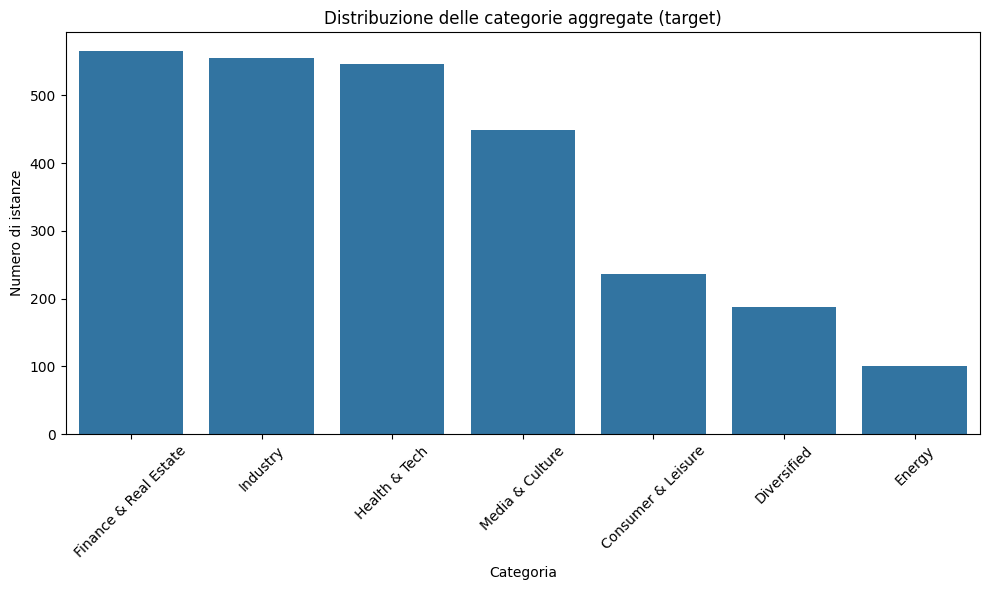

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter

# Ricarica il label encoder se sei in un nuovo notebook
le = joblib.load("../models/label_encoder_category.joblib")

# Calcola la frequenza delle classi codificate
class_counts = Counter(y_encoded)

# Costruisci il DataFrame con label decodificati
labels = [le.inverse_transform([i])[0] for i in class_counts.keys()]
counts = list(class_counts.values())

plot_df = pd.DataFrame({
    "Categoria": labels,
    "Numero di istanze": counts
}).sort_values(by="Numero di istanze", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x="Categoria", y="Numero di istanze")
plt.title("Distribuzione delle categorie aggregate (target)")
plt.ylabel("Numero di istanze")
plt.xlabel("Categoria")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
